# PLS Regression
I'm following this paper: <https://www.sciencedirect.com/science/article/pii/S1878929316301074?via%3Dihub>

In [51]:
import glob
import os

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

## Get Data

In [2]:
def get_subject_from_path(path):
    normalized_path = os.path.normpath(path)
    path_components = normalized_path.split(os.sep)
    return path_components[-2][4:]

In [3]:
# Search for all functional connectivity files and read them into a
# numpy array.
fc_path = '/imaging3/owenlab/bpho/python_power_fc'
fc_paths = glob.glob(fc_path + '/**/power_fc.npy', recursive=True)

fcs = {}
for path in fc_paths:
    subject_id = get_subject_from_path(path)
    # print(subject_id)
    subject_fc = np.load(path)
    fcs[subject_id] = subject_fc[np.triu_indices(264, k=1)]
print("Number of functional connectivities:", len(fcs))
print("Number of features (connections):", fcs["NDARAP912JK3"].shape[0])

Number of functional connectivities: 722
Number of features (connections): 34716


## Get Labels

In [55]:
wisc_label_path = "/imaging3/owenlab/bpho/Biobank Labels/Subjects with WISC.csv"
wisc_labels = pd.read_csv(wisc_label_path)
wisc_labels.set_index(keys='assessment WISC,EID', inplace=True)
# display(wisc_labels)

In [37]:
label_subject_ids = wisc_labels.index
subject_ages = wisc_labels["assessment Basic_Demos,Age"].to_numpy()
subjects_with_wisc = {}

for subject_id in label_subject_ids:
    if subject_id not in fcs:
        continue
    
    subject_wisc_fsiq_sum = wisc_labels.at[subject_id, 'assessment WISC,WISC_FSIQ']
#     if subject_wisc_fsiq_sum < 40:
#         continue
    
    subjects_with_wisc[subject_id] = (fcs[subject_id], subject_wisc_fsiq_sum)

print(len(subjects_with_wisc))

425


In [42]:
fc_matrices = []
wisc_measure = []

for features in subjects_with_wisc.values():
    fc_matrices.append(features[0])
    wisc_measure.append(features[1])

X = np.array(fc_matrices)
y = np.array(wisc_measure)
# y = np.array(subject_ages)

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (425, 34716) y shape: (425,)


## Train PLS Regression

### Determine optimal number of components

In [7]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score

kf = KFold(n_splits=10)

In [28]:
pls = PLSRegression(n_components=5)

train_scores = []
test_scores = []

In [29]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pls.fit(X_train, y_train)
    X_pls, y_pls = pls.transform(X, y)
    
    train_scores.append(pls.score(X_train, y_train))
    test_scores.append(pls.score(X_test, y_test))

print("Avg train score:", np.mean(train_scores))
print("Avg test score:", np.mean(test_scores))

Avg train score: 0.7695676699176808
Avg test score: 0.12598885221782558


In [14]:
# Y = X @ coef_
print(pls.x_weights_.shape, pls.coef_.shape)

(34716, 5) (34716, 1)


### Explained Variance
1 component = 0.065 / -0.035
2 component = 0.368 /  0.013
3 component = 0.527 / -0.003
4 component = 0.665 /  0.023
5 component = 0.791 / -0.026
6 component = 0.862 / -0.043
7 component = 0.916 / -0.056

### Use PLS to predict scores

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

In [44]:
train_scores = []
test_scores = []

for i in range(0, 1000):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)
    
    pls = PLSRegression(n_components=5)
    pls.fit(X_train, y_train)

    y_train_pred = pls.predict(X_train)
    y_test_pred = pls.predict(X_test)
    
    train_scores.append(r2_score(y_train, y_train_pred))
    test_scores.append(r2_score(y_test, y_test_pred))

print("Train r^2:", np.mean(train_scores))
print("Test r^2:", np.mean(test_scores))
    
# print("Train r^2:", r2_score(y_train, y_train_pred))
# print("Test r^2:", r2_score(y_test, y_test_pred))

Train r^2: 0.841684508458011
Test r^2: 0.061177917463166774


In [46]:
print("Train r^2:", np.median(train_scores))
print("Test r^2:", np.median(test_scores))

Train r^2: 0.8340202949925268
Test r^2: 0.06916211235221303


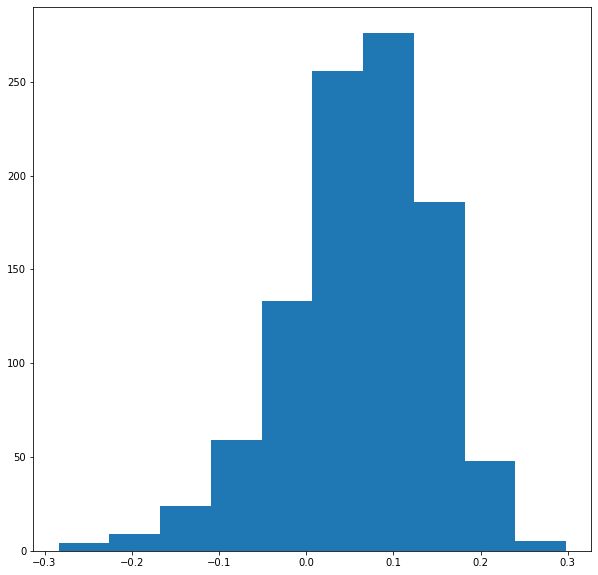

In [45]:
plt.figure(1, figsize=(10, 10))
plt.hist(x=test_scores)
plt.title("")
plt.xlabel('')
plt.ylabel('')
plt.show()

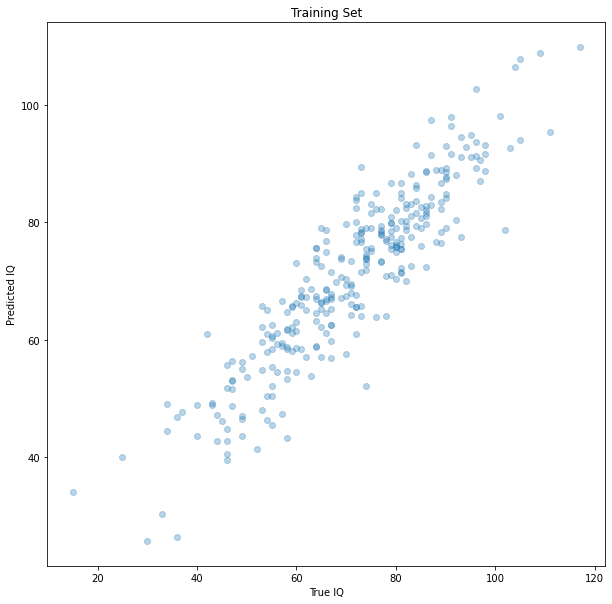

In [92]:
plt.figure(1, figsize=(10, 10))
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.title("Training Set")
plt.xlabel('True IQ')
plt.ylabel('Predicted IQ')
plt.show()

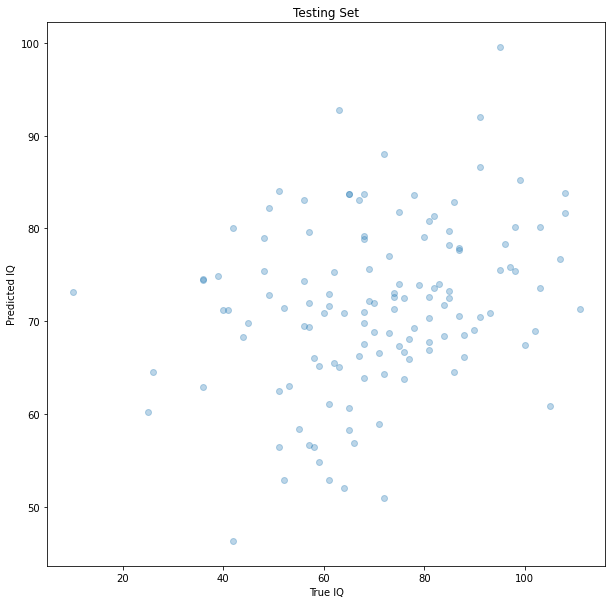

In [93]:
plt.figure(1, figsize=(10, 10))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.title("Testing Set")
plt.xlabel('True IQ')
plt.ylabel('Predicted IQ')
plt.show()